Goal: Predict closing prices or detect potential trading signals.using lstm

In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [306]:
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [307]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'JPM_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)

In [308]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.83,40.36,39.30,40.19,12839400,JPM
1,2006-01-04,39.78,40.14,39.42,39.62,13491800,JPM
2,2006-01-05,39.61,39.81,39.50,39.74,8109400,JPM
3,2006-01-06,39.92,40.24,39.55,40.02,7966900,JPM
4,2006-01-09,39.88,40.72,39.88,40.67,16575200,JPM


In [309]:
diff_close_series = df['Close'].diff().dropna()

dont make lag feature of actual value make lag feature of diffrences of the values


In [310]:
lagged_data = pd.concat(
    [diff_close_series.shift(i) for i in range(5, -1, -1)],
    axis=1
).dropna()
lagged_data.columns = [f'lag_{i}' for i in range(5, -1, -1)]
X = lagged_data.iloc[:, 1:].values 
y = lagged_data.iloc[:, 0].values   

In [311]:
# lag_df['diff t-1'] = lag_df['t'] - lag_df['t-1'] 
# lag_df['diff t'] = lag_df['t+1'] - lag_df['t']   

In [312]:
# lag_df['rolling_mean_7'] = lag_df['t'].rolling(window=7).mean()
# lag_df['rolling_std_7'] = lag_df['t'].rolling(window=7).std()
# lag_df.dropna(inplace=True)

In [313]:
# X = lag_df[['diff t-1', 't']].values  
# y = lag_df['t+1'].values

In [314]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [315]:

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [316]:
# X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [317]:
X_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

In [318]:
# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(1, X_reshaped.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [319]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_reshaped.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [320]:
# history = model.fit(X_reshaped, y_scaled, epochs=100, batch_size=16, verbose=1, validation_split=0.2)

In [321]:
model.fit(X_reshaped, y_scaled, epochs=200, batch_size=8, verbose=0)

In [322]:
y_pred_scaled = model.predict(X_reshaped)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [323]:
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

In [326]:
print(f"MSE: {mse:.6f}")
print(f"R2: {r2:.6f}")

MSE: 0.523759
R2: 0.475302


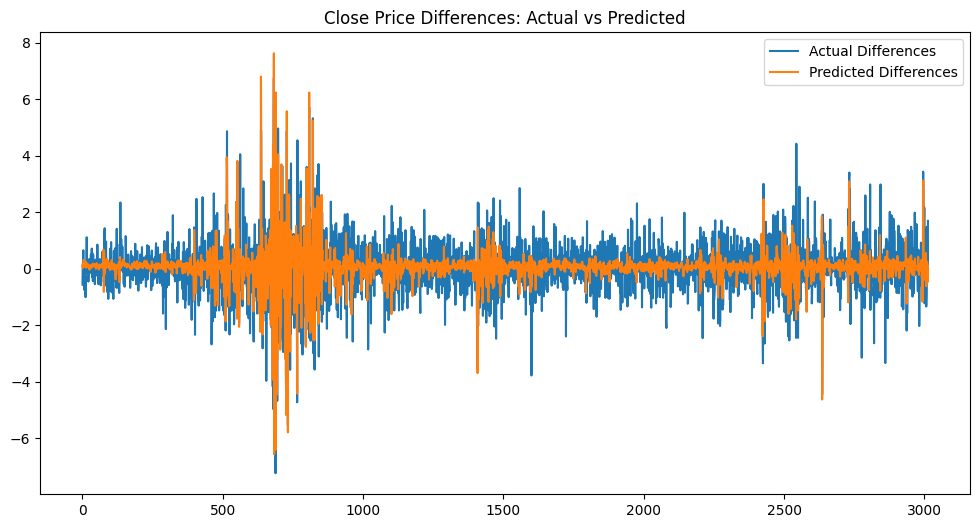

In [325]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual Differences')
plt.plot(y_pred, label='Predicted Differences')
plt.title("Close Price Differences: Actual vs Predicted")
plt.legend()
plt.show()

arima

In [328]:
 split_idx = int(len(diff_close_series) * 0.8)
train, test = diff_close_series[:split_idx], diff_close_series[split_idx:]

In [329]:
model_arima = ARIMA(train, order=(1, 0, 1))
model_arima_fit = model_arima.fit()

/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [330]:
forecast_arima = model_arima_fit.forecast(steps=len(test))

/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [332]:
mse_arima = mean_squared_error(test, forecast_arima)
mse_arima

0.9436441688778471

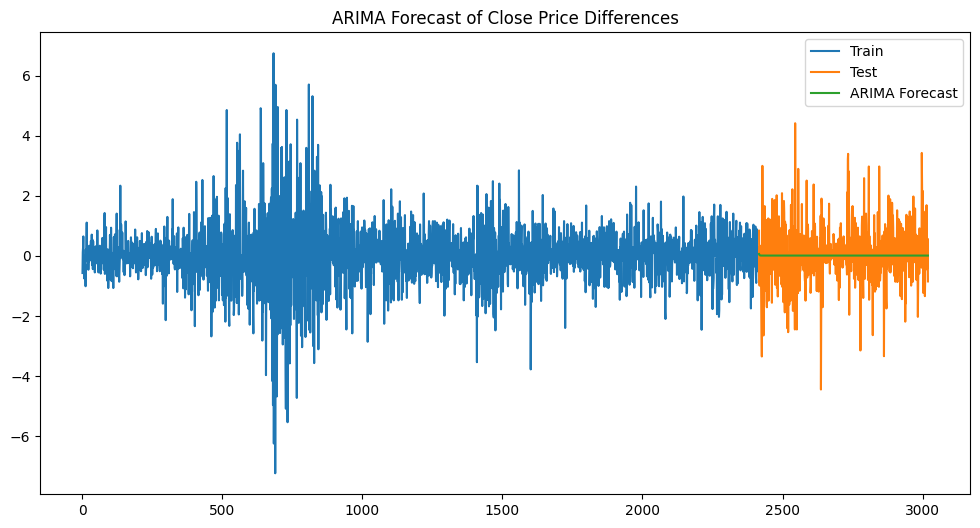

In [333]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.title("ARIMA Forecast of Close Price Differences")
plt.legend()
plt.show()

In [335]:
model_sarima = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_sarima_fit = model_sarima.fit(disp=False)

/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [336]:
forecast_sarima = model_sarima_fit.forecast(steps=len(test))

/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [337]:
mse_sarima = mean_squared_error(test, forecast_sarima)
print(f"SARIMA MSE: {mse_sarima:.6f}")

SARIMA MSE: 0.945433


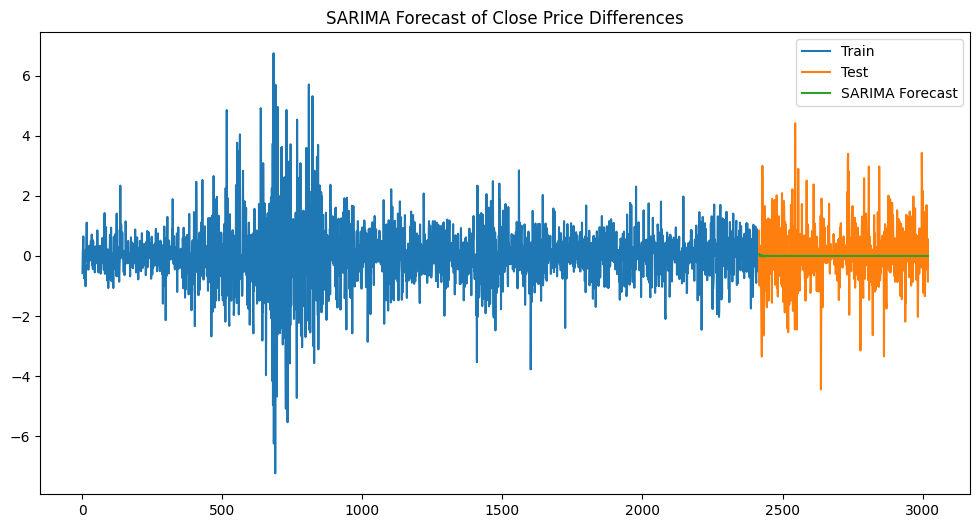

In [338]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast')
plt.title("SARIMA Forecast of Close Price Differences")
plt.legend()
plt.show()